In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


1237658312408301638.npy
1237668314847182934.npy
1237664854187049228.npy
1237665329320624279.npy
1237662225696227493.npy


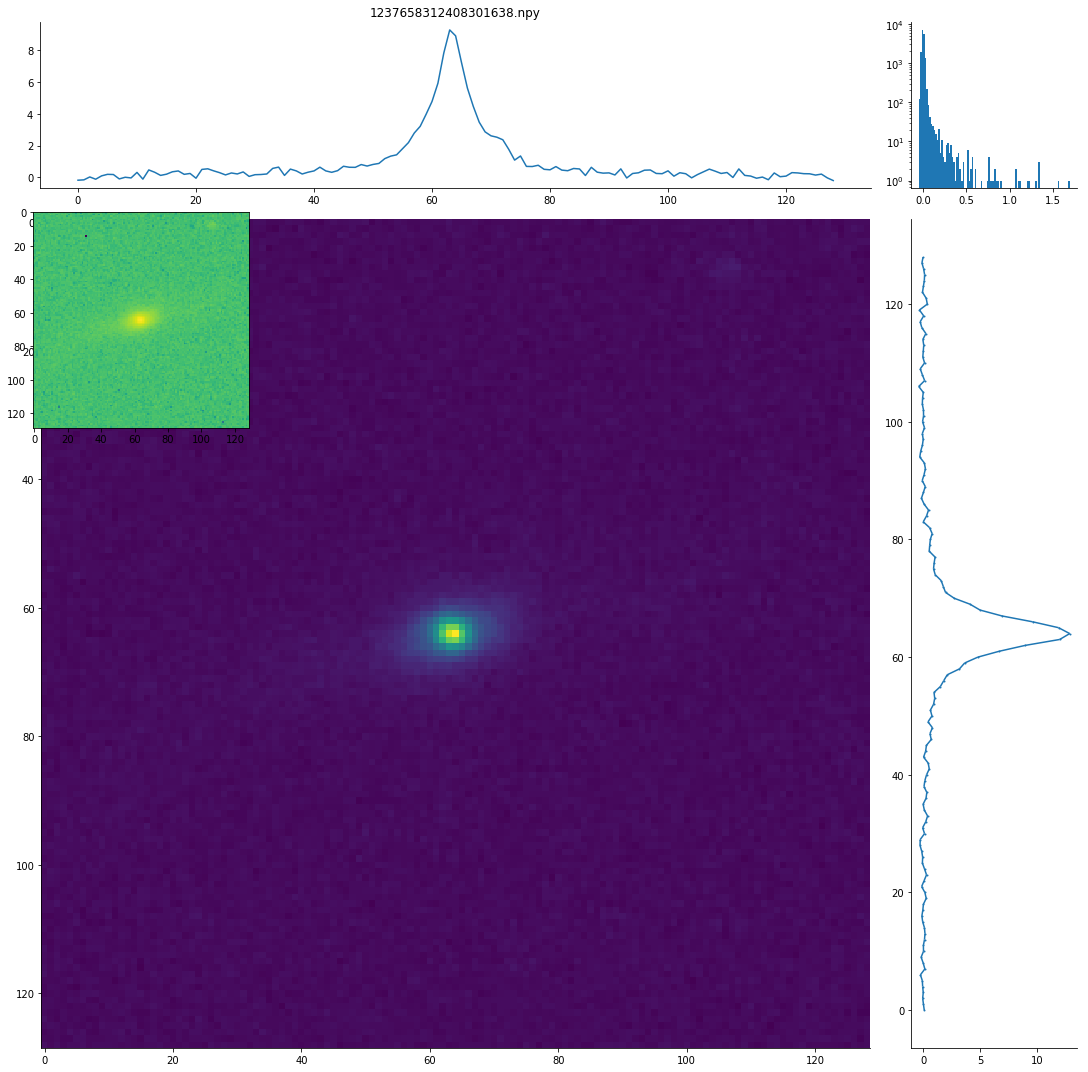

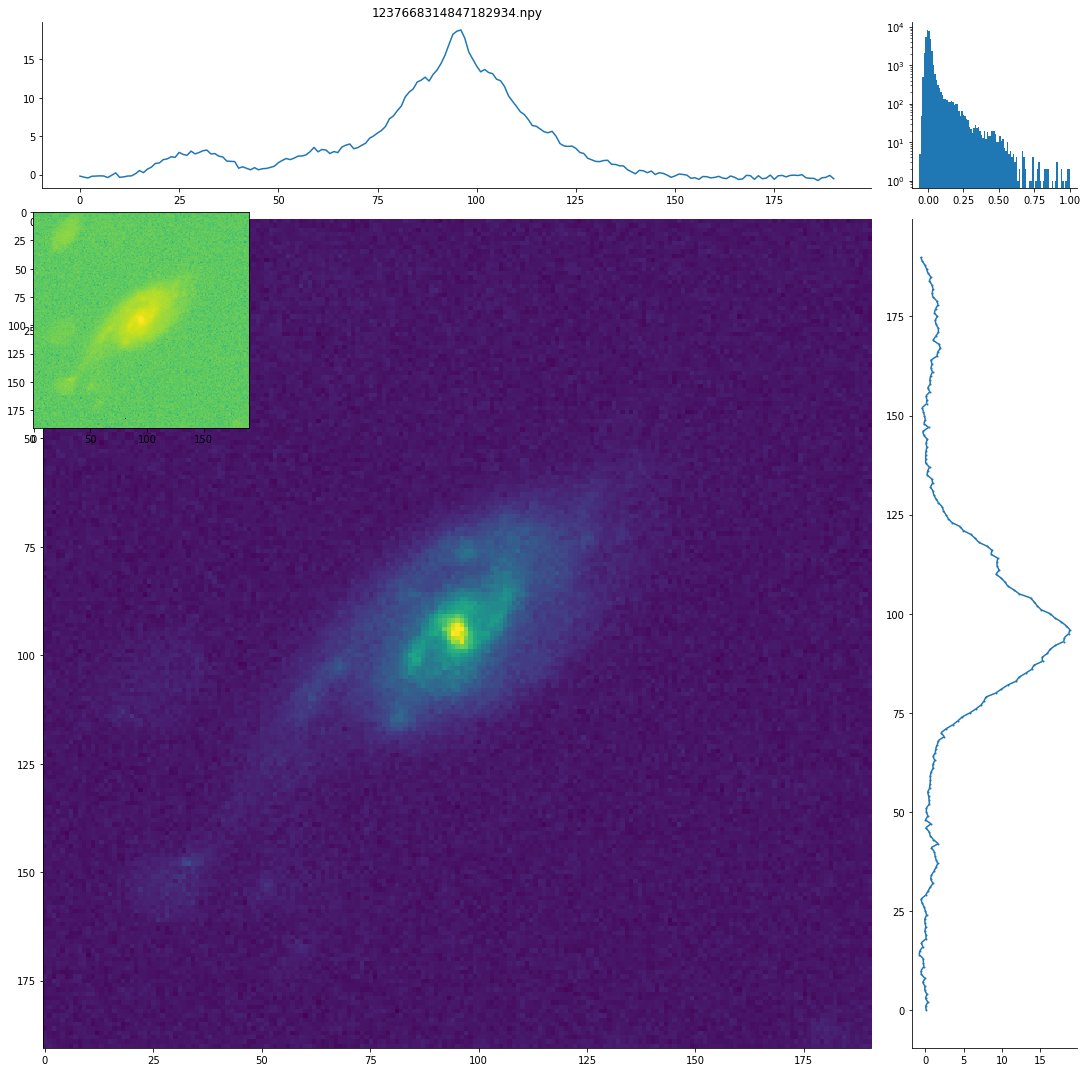

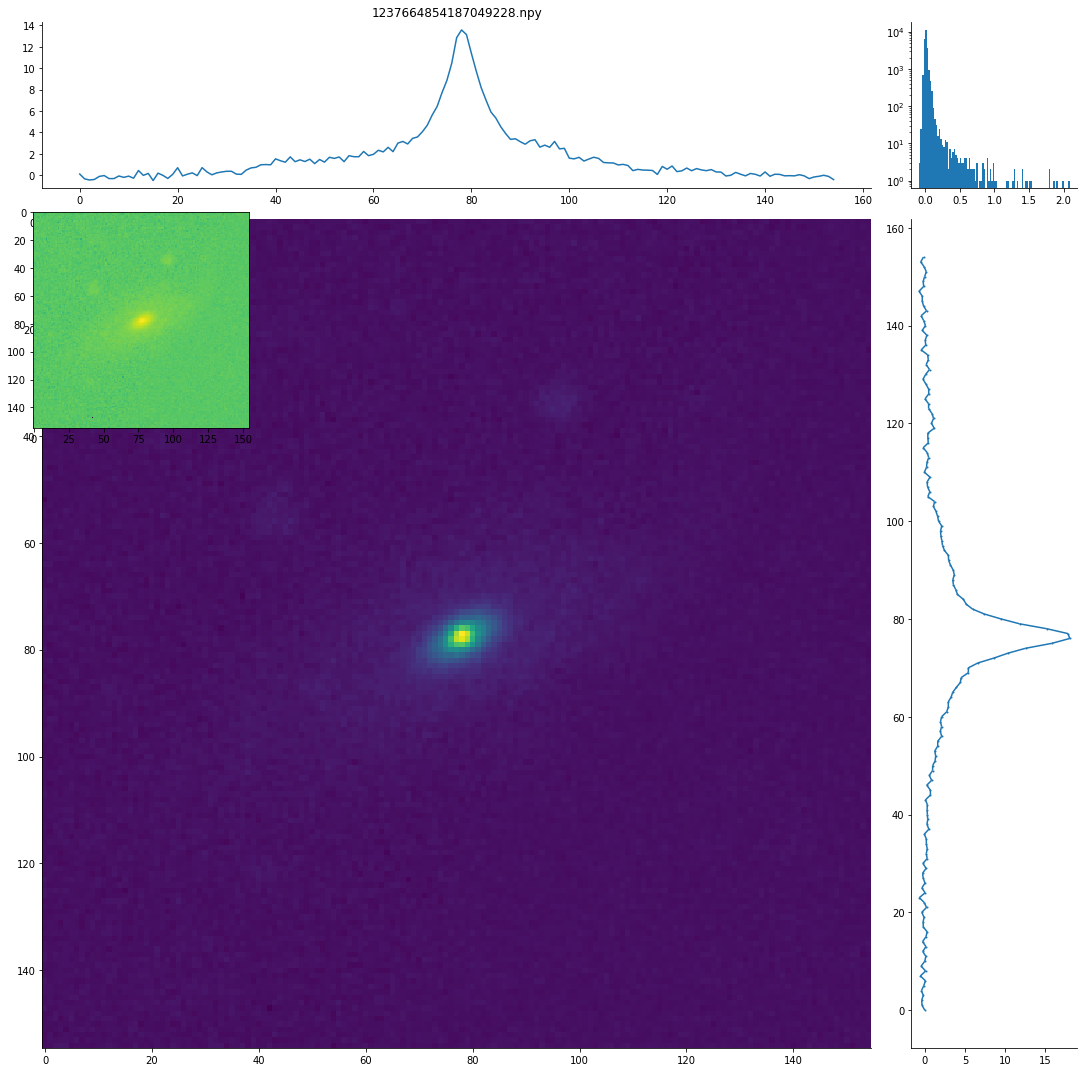

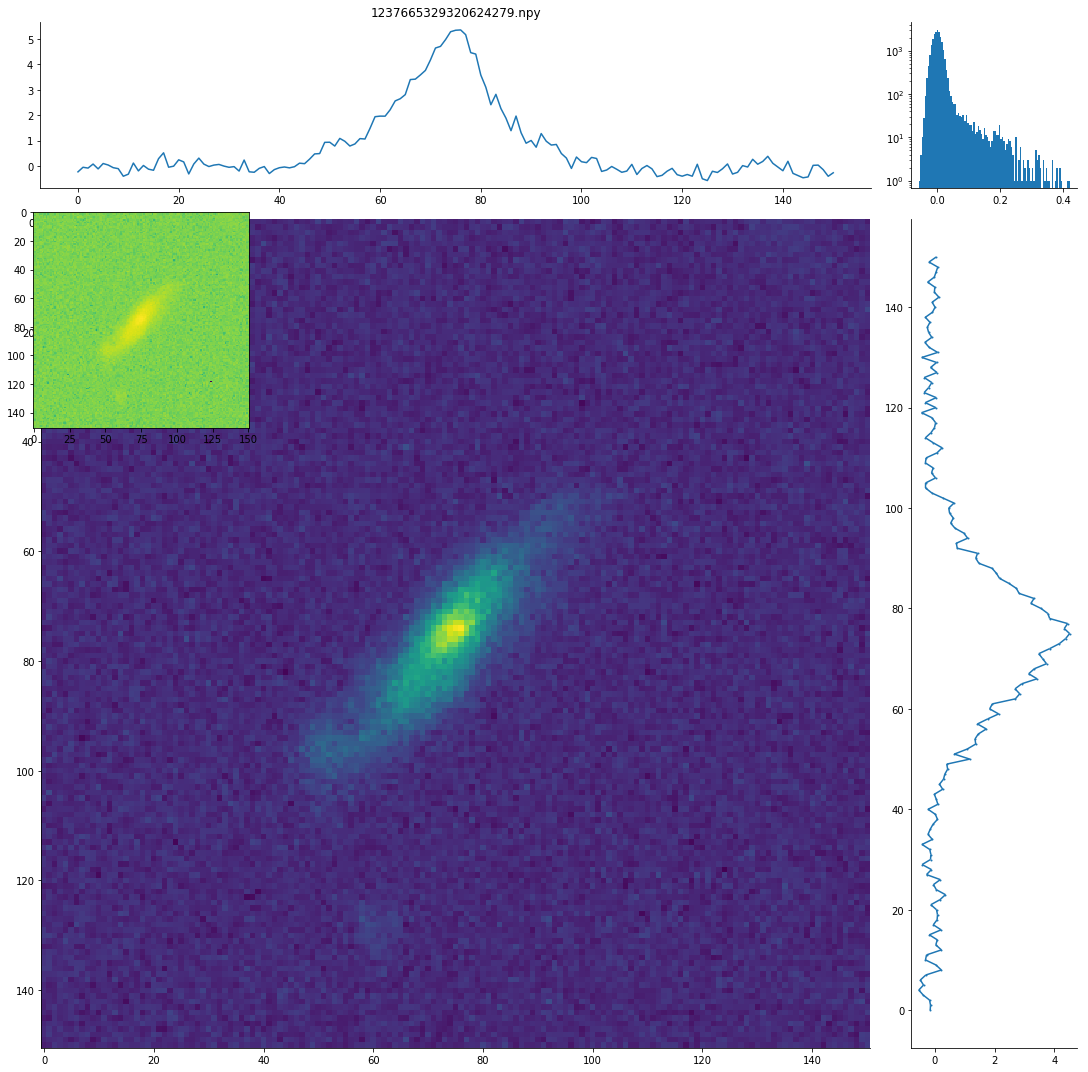

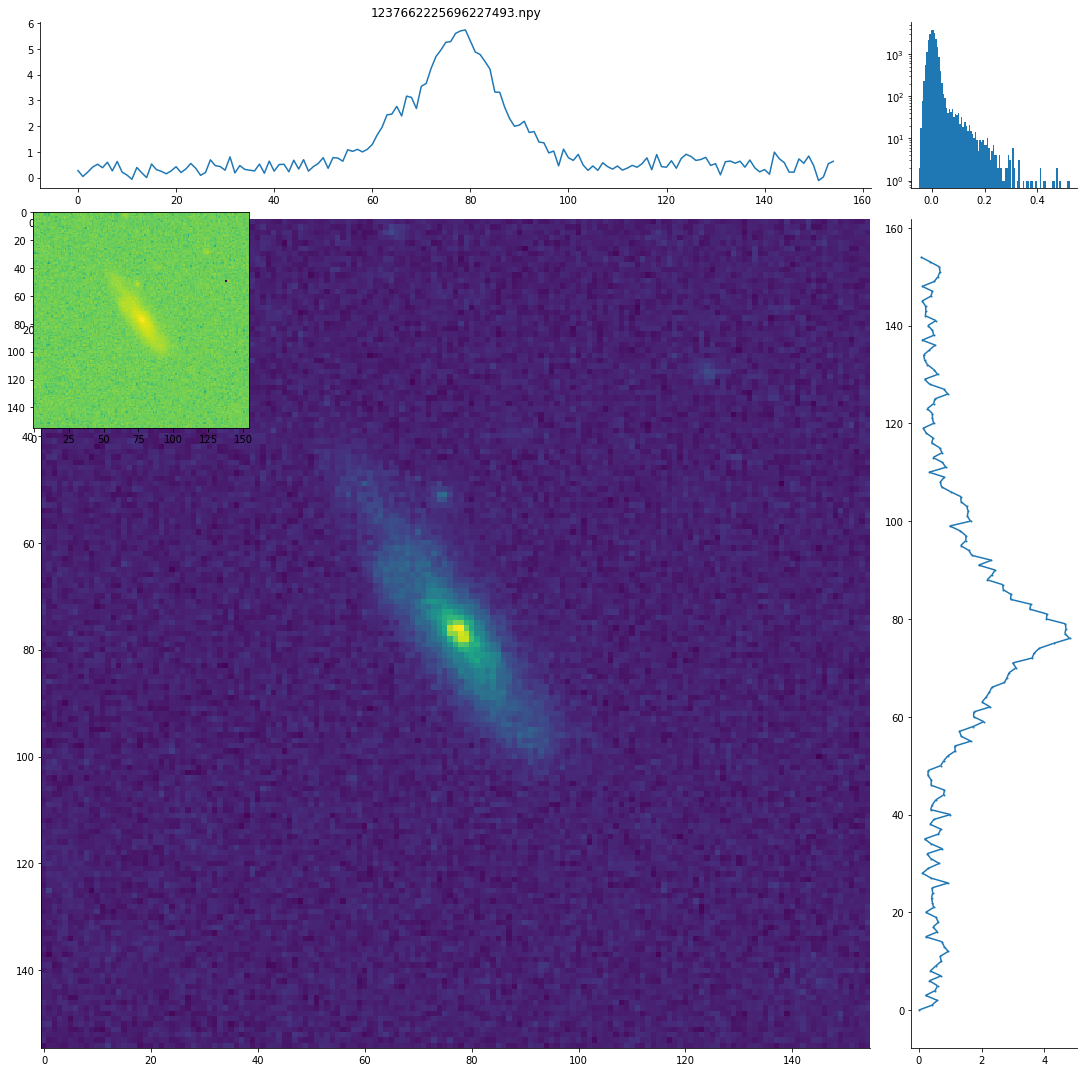

In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg):
#    Xg = cleanupImage(id)
    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id):
    Xg = read_image(id)
    return img_preprocnoread(Xg)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-1.76538 25.1189
[[-0.25426349 -0.25737935 -0.26957193 -0.28176448 -0.16600797]
 [-0.23498572 -0.23899144 -0.25466603 -0.27034062 -0.15546009]
 [-0.15955099 -0.16703874 -0.19633867 -0.22563858 -0.11418581]
 [-0.08411626 -0.09508604 -0.13801129 -0.18093653 -0.07291152]
 [ 0.00350935 -0.02360988 -0.1297286  -0.23584734 -0.20728627]]


1

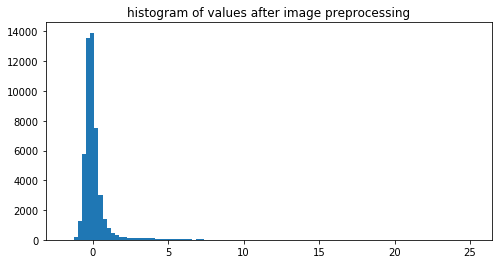

In [12]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [13]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [14]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [15]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [16]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [17]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [18]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237650369947435223,185.44185,-3.08192,0.416869,0.0897,46.616726,384.4285649912698,0.745505,11.302,0.022,384.428565,2.004472e+11,1.015403e+10,True
1,1237662263778410573,211.48530,9.02645,1.023293,0.0233,29.723862,99.85714086464473,0.193648,10.524,0.017,99.857141,3.341950e+10,1.308171e+09,True
2,1237654881815757047,226.44975,4.93666,0.524807,0.0801,52.406104,343.28571387699674,0.665718,11.072,0.012,343.285714,1.180321e+11,3.261346e+09,True
3,1237661463301914866,234.70845,33.98374,0.407380,0.0734,37.277381,314.5714210612433,0.610034,10.637,0.013,314.571421,4.335109e+10,1.297654e+09,True
4,1237655463240269922,220.99650,55.96656,0.501187,0.0759,47.423228,325.2857284886496,0.630812,11.275,0.024,325.285728,1.883649e+11,1.040943e+10,True


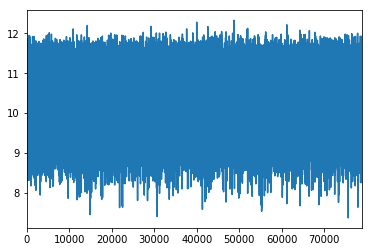

In [20]:
df.logMstar.plot()

In [21]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [22]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [23]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [24]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
500
sp-newSource-ReadLog1pNormCrop.75


In [25]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [26]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [27]:
reloadImagesAndPreprocess = 0
maxChunkNumber = math.ceil(len(ids)/chunkSize)

Xg3r50 = []
Xg3vgg16 = []
postImgFeatures = []
csize=2
preImgFeatures = []

chunkStart = 0
# for chunkStart in tqdm(range(0, 3)):
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg_ = []
    pre_ex_ = []

    # preprocess the image and collect some raw image stats
    for i in range(chunkStart, chunkStart+valuesInThisChunk):
        X = read_image(ids[i])
        Xg_.append(img_preprocnoread(X))
        pre_ex_.append([
            X.sum(),
            X.min(),
            X.max(),
            X.mean(),
            X.std(),
            X[X.shape[0]//2,X.shape[1]//2],
            np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
            X.shape[0], 
        ])

    # reformat the postprocessing
    pre_ex = np.stack(pre_ex_)
    Xg = np.stack(Xg_)

    # collect some post processing stats
    post_ex = np.hstack([
        np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    Xg3 = np.zeros((valuesInThisChunk,224,224,3))
    Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)
    
    # do r50 prediction
    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)


    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        preImgFeatures = pre_ex
        postImgFeatures = post_ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
        postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)
        
print('done')

postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']



100%|██████████| 158/158 [10:50<00:00,  4.00s/it]

done


In [28]:
Xg3 = None
Xg = None
X = None


In [29]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        preImgFeatures,
        postImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [30]:
prefixThisRound = prefixThisRound + '-model5'

In [31]:
# extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
            + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3075 (78851, 3075)


In [32]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

(78851, 3075)
(78851, 14)


In [33]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [34]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [35]:
# N = len(df.SDSS_ID.values)
# M = 4000

# N = 10000
# M = 10000
print(M, N)

70965 78851


In [36]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [37]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [38]:
# useless cv if not used
# bst=lgbm.cv(lgbm_params, dtrain, num_boost_round=10000, nfold=3, stratified=False, shuffle=True,
#               metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto',
#               categorical_feature='auto', early_stopping_rounds=100, fpreproc=None,
#               verbose_eval=5, show_stdv=True, seed=0, callbacks=None)



In [39]:

# num_boost_round = len(bst['rmse-mean'])-1
num_boost_round = 29999
print(num_boost_round)


29999


In [40]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

In [41]:
model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=lgb_rmsle, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=20, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[20]	test's rmse: 0.567594	test's rmsle: 0.00258645
[40]	test's rmse: 0.496652	test's rmsle: 0.0019931
[60]	test's rmse: 0.439024	test's rmsle: 0.0015646
[80]	test's rmse: 0.392824	test's rmsle: 0.00125575
[100]	test's rmse: 0.35595	test's rmsle: 0.00103183
[120]	test's rmse: 0.326386	test's rmsle: 0.000867249
[140]	test's rmse: 0.302919	test's rmsle: 0.0007464
[160]	test's rmse: 0.28487	test's rmsle: 0.000659204
[180]	test's rmse: 0.270899	test's rmsle: 0.000595307
[200]	test's rmse: 0.259698	test's rmsle: 0.000546494
[220]	test's rmse: 0.250647	test's rmsle: 0.000508475
[240]	test's rmse: 0.243266	test's rmsle: 0.000478435
[260]	test's rmse: 0.237397	test's rmsle: 0.000455237
[280]	test's rmse: 0.232563	test's rmsle: 0.000436644
[300]	test's rmse: 0.22863	test's rmsle: 0.000421891
[320]	test's rmse: 0.225267	test's rmsle: 0.000409451
[340]	test's rmse: 0.222323	test's rmsle: 0.000398714
[360]	test's rmse: 0.21971	test's r

[3020]	test's rmse: 0.181295	test's rmsle: 0.000265488
[3040]	test's rmse: 0.181272	test's rmsle: 0.000265423
[3060]	test's rmse: 0.18124	test's rmsle: 0.000265332
[3080]	test's rmse: 0.181198	test's rmsle: 0.00026521
[3100]	test's rmse: 0.181159	test's rmsle: 0.000265096
[3120]	test's rmse: 0.181138	test's rmsle: 0.00026504
[3140]	test's rmse: 0.181129	test's rmsle: 0.000265014
[3160]	test's rmse: 0.181104	test's rmsle: 0.000264935
[3180]	test's rmse: 0.181065	test's rmsle: 0.000264827
[3200]	test's rmse: 0.181034	test's rmsle: 0.000264738
[3220]	test's rmse: 0.181	test's rmsle: 0.000264641
[3240]	test's rmse: 0.180961	test's rmsle: 0.000264531
[3260]	test's rmse: 0.180922	test's rmsle: 0.000264427
[3280]	test's rmse: 0.180896	test's rmsle: 0.000264353
[3300]	test's rmse: 0.180866	test's rmsle: 0.000264268
[3320]	test's rmse: 0.180831	test's rmsle: 0.00026417
[3340]	test's rmse: 0.180805	test's rmsle: 0.000264097
[3360]	test's rmse: 0.180772	test's rmsle: 0.000264
[3380]	test's rmse: 

[6020]	test's rmse: 0.178198	test's rmsle: 0.0002566
[6040]	test's rmse: 0.178181	test's rmsle: 0.000256549
[6060]	test's rmse: 0.178159	test's rmsle: 0.000256489
[6080]	test's rmse: 0.178158	test's rmsle: 0.000256485
[6100]	test's rmse: 0.17815	test's rmsle: 0.000256456
[6120]	test's rmse: 0.178139	test's rmsle: 0.000256427
[6140]	test's rmse: 0.178124	test's rmsle: 0.000256384
[6160]	test's rmse: 0.178105	test's rmsle: 0.000256332
[6180]	test's rmse: 0.178099	test's rmsle: 0.000256313
[6200]	test's rmse: 0.178089	test's rmsle: 0.000256286
[6220]	test's rmse: 0.178083	test's rmsle: 0.000256268
[6240]	test's rmse: 0.178071	test's rmsle: 0.000256235
[6260]	test's rmse: 0.178064	test's rmsle: 0.000256214
[6280]	test's rmse: 0.178041	test's rmsle: 0.000256153
[6300]	test's rmse: 0.178032	test's rmsle: 0.000256129
[6320]	test's rmse: 0.178017	test's rmsle: 0.000256085
[6340]	test's rmse: 0.178002	test's rmsle: 0.000256041
[6360]	test's rmse: 0.177986	test's rmsle: 0.000255994
[6380]	test's

[9020]	test's rmse: 0.176771	test's rmsle: 0.000252551
[9040]	test's rmse: 0.176769	test's rmsle: 0.000252549
[9060]	test's rmse: 0.176763	test's rmsle: 0.000252533
[9080]	test's rmse: 0.176745	test's rmsle: 0.000252484
[9100]	test's rmse: 0.176738	test's rmsle: 0.000252468
[9120]	test's rmse: 0.176735	test's rmsle: 0.00025246
[9140]	test's rmse: 0.176737	test's rmsle: 0.000252465
[9160]	test's rmse: 0.176733	test's rmsle: 0.000252452
[9180]	test's rmse: 0.176728	test's rmsle: 0.000252444
[9200]	test's rmse: 0.176723	test's rmsle: 0.000252431
[9220]	test's rmse: 0.176707	test's rmsle: 0.000252385
[9240]	test's rmse: 0.176693	test's rmsle: 0.000252345
[9260]	test's rmse: 0.176679	test's rmsle: 0.000252309
[9280]	test's rmse: 0.176659	test's rmsle: 0.000252254
[9300]	test's rmse: 0.176652	test's rmsle: 0.000252232
[9320]	test's rmse: 0.176644	test's rmsle: 0.00025221
[9340]	test's rmse: 0.176636	test's rmsle: 0.000252188
[9360]	test's rmse: 0.176629	test's rmsle: 0.000252167
[9380]	test'

[11980]	test's rmse: 0.175781	test's rmsle: 0.000249791
[12000]	test's rmse: 0.175779	test's rmsle: 0.000249785
[12020]	test's rmse: 0.175777	test's rmsle: 0.000249777
[12040]	test's rmse: 0.175774	test's rmsle: 0.000249771
[12060]	test's rmse: 0.175768	test's rmsle: 0.000249753
[12080]	test's rmse: 0.175766	test's rmsle: 0.000249748
[12100]	test's rmse: 0.175769	test's rmsle: 0.000249758
[12120]	test's rmse: 0.175763	test's rmsle: 0.000249743
[12140]	test's rmse: 0.175762	test's rmsle: 0.000249742
[12160]	test's rmse: 0.175759	test's rmsle: 0.000249735
[12180]	test's rmse: 0.175756	test's rmsle: 0.000249724
[12200]	test's rmse: 0.175756	test's rmsle: 0.000249724
[12220]	test's rmse: 0.17576	test's rmsle: 0.000249737
[12240]	test's rmse: 0.175756	test's rmsle: 0.000249726
[12260]	test's rmse: 0.17575	test's rmsle: 0.000249705
[12280]	test's rmse: 0.175744	test's rmsle: 0.00024969
[12300]	test's rmse: 0.175736	test's rmsle: 0.000249667
[12320]	test's rmse: 0.175734	test's rmsle: 0.00024

In [42]:
pred = model.predict(Xg3f[M:])

In [43]:
print(Y[M:].shape)
print(pred.shape)

(7886,)
(7886,)


In [44]:
chiSq = xi2(Y[M:],pred,err[M:])
linChiSq = xi2(10**Y[M:],10**pred,err_lin[M:])
print(chiSq)
print(linChiSq)


60.9081327724
97.7560407261


In [45]:
print(N,(M,N-M), prefixThisRound, chiSq, linChiSq)
# 7885 (6308, 1577) sp-newSource-ReadNormCrop.5-model1 65.6004981632 289.265891446
# 78851 (63080, 15771) sp-newSource-ReadNormCrop.5-model1 101.26977686 3634.92854724
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1 84.7537916939 112.786722095
# 78851 (70965, 7886) sp-newSource-ReadNormCrop.5-model1-model2 76.9540798979 106.544584929
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.5-model3 64.4120566007 82.1151002172
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.2302974915 78.0009050209
# 78851 (70965, 7886) sp-newSource-ReadLog1pCrop.75Norm-model4 74.433987693 104.167079904
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 66.7288440316 76.8328009721
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 65.4574681665 81.7908427327
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model4 72.7632221466 98.9424959642
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.6-model5 69.4944311297 99.8518732071
# 78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 60.9081327724 97.7560407261

78851 (70965, 7886) sp-newSource-ReadLog1pNormCrop.75-model5 60.9081327724 97.7560407261


In [46]:
# investigateIDOffset = 2815

# df.loc[M+investigateIDOffset,:]

# print(10**pred[investigateIDOffset]/10**Y[M+investigateIDOffset], 10**Y[M+investigateIDOffset])

# drawOneGalaxy(df.loc[M+investigateIDOffset,'SDSS_ID'])

In [47]:
# def xi2_max(true,pred,error):
#     s=np.argmax((true-pred)**2/error**2)
    
#     plt.hist(np.log(0.00001+(true-pred)**2/error**2),bins=100)
#     return s

In [48]:
# # M = N-4000
# pred[2815] = Y[M+2815]

# print( xi2_max(10**Y[M:],10**pred,err_lin[M:]))


# Same but with Cross Validation

In [ ]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [63]:
from sklearn.model_selection import *

In [88]:
nSplits = 5
kf = KFold(n_splits=nSplits,shuffle=True, random_state=220673)

ppreds = np.zeros([len(Xg3f),nSplits])
models = []
counter = 0
for tix, vix in kf.split(Xg3f):
    X_train, X_test = Xg3f[tix], Xg3f[vix]
    Y_train, Y_test = Y[tix], Y[vix]
    
    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)
    
    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=20000,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100
                    )
    models.append(gbm)
    p = gbm.predict(X_test)
    ppreds[vix,counter] = p
    counter = counter+1

    
# def lgb_r2(y_pred,y_true):
#    return ‘r2’, r2_score(y_true.get_label(),y_pred), True


# [6:28] 
# gbm.predict(X_test,gbm.best_iteration)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356673	valid_1's rmse: 0.353734
[200]	training's rmse: 0.259591	valid_1's rmse: 0.258553
[300]	training's rmse: 0.227103	valid_1's rmse: 0.228087
[400]	training's rmse: 0.212825	valid_1's rmse: 0.21536
[500]	training's rmse: 0.204029	valid_1's rmse: 0.207806
[600]	training's rmse: 0.197674	valid_1's rmse: 0.202785
[700]	training's rmse: 0.192857	valid_1's rmse: 0.199318
[800]	training's rmse: 0.188904	valid_1's rmse: 0.196659
[900]	training's rmse: 0.18563	valid_1's rmse: 0.194629
[1000]	training's rmse: 0.182831	valid_1's rmse: 0.193039
[1100]	training's rmse: 0.180344	valid_1's rmse: 0.191723
[1200]	training's rmse: 0.178167	valid_1's rmse: 0.19066
[1300]	training's rmse: 0.176195	valid_1's rmse: 0.189845
[1400]	training's rmse: 0.17441	valid_1's rmse: 0.18912
[1500]	training's rmse: 0.172735	valid_1's rmse: 0.188491
[1600]	training's rmse: 0.171171	valid_1's rmse: 0.187953
[1700]	training's rmse:

[14200]	training's rmse: 0.0973873	valid_1's rmse: 0.178836
[14300]	training's rmse: 0.0970532	valid_1's rmse: 0.178828
[14400]	training's rmse: 0.0967237	valid_1's rmse: 0.178817
[14500]	training's rmse: 0.0963938	valid_1's rmse: 0.178801
[14600]	training's rmse: 0.0960507	valid_1's rmse: 0.17879
[14700]	training's rmse: 0.0957276	valid_1's rmse: 0.178779
[14800]	training's rmse: 0.095413	valid_1's rmse: 0.178777
[14900]	training's rmse: 0.0950825	valid_1's rmse: 0.178772
Early stopping, best iteration is:
[14895]	training's rmse: 0.0950986	valid_1's rmse: 0.178769
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.355863	valid_1's rmse: 0.358915
[200]	training's rmse: 0.258765	valid_1's rmse: 0.263074
[300]	training's rmse: 0.226549	valid_1's rmse: 0.231513
[400]	training's rmse: 0.212436	valid_1's rmse: 0.218132
[500]	training's rmse: 0.20375	valid_1's rmse: 0.210319
[600]	training's rmse: 0.197525	valid_1's rmse: 0.204952
[700]	training's rmse: 

[13200]	training's rmse: 0.101069	valid_1's rmse: 0.179535
[13300]	training's rmse: 0.100709	valid_1's rmse: 0.179519
[13400]	training's rmse: 0.100357	valid_1's rmse: 0.179512
[13500]	training's rmse: 0.100018	valid_1's rmse: 0.179496
[13600]	training's rmse: 0.0996613	valid_1's rmse: 0.179484
[13700]	training's rmse: 0.099314	valid_1's rmse: 0.179471
[13800]	training's rmse: 0.0989779	valid_1's rmse: 0.179464
[13900]	training's rmse: 0.0986304	valid_1's rmse: 0.179455
[14000]	training's rmse: 0.0982957	valid_1's rmse: 0.179449
[14100]	training's rmse: 0.0979465	valid_1's rmse: 0.179434
[14200]	training's rmse: 0.0976091	valid_1's rmse: 0.179421
[14300]	training's rmse: 0.0972768	valid_1's rmse: 0.179412
[14400]	training's rmse: 0.0969396	valid_1's rmse: 0.1794
[14500]	training's rmse: 0.0966063	valid_1's rmse: 0.179394
[14600]	training's rmse: 0.0962852	valid_1's rmse: 0.179387
[14700]	training's rmse: 0.0959499	valid_1's rmse: 0.179368
[14800]	training's rmse: 0.0956253	valid_1's rm

[10100]	training's rmse: 0.112503	valid_1's rmse: 0.183034
[10200]	training's rmse: 0.11208	valid_1's rmse: 0.183004
[10300]	training's rmse: 0.111662	valid_1's rmse: 0.182978
[10400]	training's rmse: 0.111239	valid_1's rmse: 0.182955
[10500]	training's rmse: 0.110826	valid_1's rmse: 0.182922
[10600]	training's rmse: 0.110414	valid_1's rmse: 0.182905
[10700]	training's rmse: 0.109999	valid_1's rmse: 0.182879
[10800]	training's rmse: 0.109587	valid_1's rmse: 0.182847
[10900]	training's rmse: 0.109176	valid_1's rmse: 0.18282
[11000]	training's rmse: 0.108768	valid_1's rmse: 0.18278
[11100]	training's rmse: 0.108365	valid_1's rmse: 0.182759
[11200]	training's rmse: 0.10796	valid_1's rmse: 0.182737
[11300]	training's rmse: 0.107565	valid_1's rmse: 0.182712
[11400]	training's rmse: 0.107177	valid_1's rmse: 0.182694
[11500]	training's rmse: 0.106793	valid_1's rmse: 0.182664
[11600]	training's rmse: 0.106403	valid_1's rmse: 0.18264
[11700]	training's rmse: 0.106016	valid_1's rmse: 0.182621
[1

[5800]	training's rmse: 0.135307	valid_1's rmse: 0.183152
[5900]	training's rmse: 0.134687	valid_1's rmse: 0.183085
[6000]	training's rmse: 0.134094	valid_1's rmse: 0.183039
[6100]	training's rmse: 0.133485	valid_1's rmse: 0.182966
[6200]	training's rmse: 0.132893	valid_1's rmse: 0.182901
[6300]	training's rmse: 0.132304	valid_1's rmse: 0.182857
[6400]	training's rmse: 0.131723	valid_1's rmse: 0.1828
[6500]	training's rmse: 0.131151	valid_1's rmse: 0.182741
[6600]	training's rmse: 0.130579	valid_1's rmse: 0.182684
[6700]	training's rmse: 0.130031	valid_1's rmse: 0.182646
[6800]	training's rmse: 0.129479	valid_1's rmse: 0.182599
[6900]	training's rmse: 0.128931	valid_1's rmse: 0.182541
[7000]	training's rmse: 0.128389	valid_1's rmse: 0.182498
[7100]	training's rmse: 0.127842	valid_1's rmse: 0.182447
[7200]	training's rmse: 0.127297	valid_1's rmse: 0.182392
[7300]	training's rmse: 0.126749	valid_1's rmse: 0.182344
[7400]	training's rmse: 0.126216	valid_1's rmse: 0.18229
[7500]	training's

[200]	training's rmse: 0.259556	valid_1's rmse: 0.26077
[300]	training's rmse: 0.227434	valid_1's rmse: 0.22844
[400]	training's rmse: 0.213304	valid_1's rmse: 0.214956
[500]	training's rmse: 0.204648	valid_1's rmse: 0.207099
[600]	training's rmse: 0.198307	valid_1's rmse: 0.201546
[700]	training's rmse: 0.193512	valid_1's rmse: 0.197679
[800]	training's rmse: 0.189572	valid_1's rmse: 0.194797
[900]	training's rmse: 0.186276	valid_1's rmse: 0.19264
[1000]	training's rmse: 0.183478	valid_1's rmse: 0.19093
[1100]	training's rmse: 0.180969	valid_1's rmse: 0.189575
[1200]	training's rmse: 0.178752	valid_1's rmse: 0.18848
[1300]	training's rmse: 0.176738	valid_1's rmse: 0.187544
[1400]	training's rmse: 0.174934	valid_1's rmse: 0.186774
[1500]	training's rmse: 0.173265	valid_1's rmse: 0.186143
[1600]	training's rmse: 0.171681	valid_1's rmse: 0.185622
[1700]	training's rmse: 0.17019	valid_1's rmse: 0.18513
[1800]	training's rmse: 0.168824	valid_1's rmse: 0.184722
[1900]	training's rmse: 0.167

[14400]	training's rmse: 0.096996	valid_1's rmse: 0.176179
[14500]	training's rmse: 0.0966713	valid_1's rmse: 0.176169
[14600]	training's rmse: 0.0963392	valid_1's rmse: 0.176156
[14700]	training's rmse: 0.0960082	valid_1's rmse: 0.176131
[14800]	training's rmse: 0.0956865	valid_1's rmse: 0.176114
[14900]	training's rmse: 0.095362	valid_1's rmse: 0.176094
[15000]	training's rmse: 0.0950376	valid_1's rmse: 0.17608
[15100]	training's rmse: 0.0947079	valid_1's rmse: 0.176072
[15200]	training's rmse: 0.0943828	valid_1's rmse: 0.176061
[15300]	training's rmse: 0.0940689	valid_1's rmse: 0.17604
[15400]	training's rmse: 0.0937425	valid_1's rmse: 0.176028
[15500]	training's rmse: 0.0934244	valid_1's rmse: 0.176017
[15600]	training's rmse: 0.0931127	valid_1's rmse: 0.176005
[15700]	training's rmse: 0.0928002	valid_1's rmse: 0.175992
[15800]	training's rmse: 0.0924841	valid_1's rmse: 0.17598
[15900]	training's rmse: 0.0921842	valid_1's rmse: 0.175973
[16000]	training's rmse: 0.0918648	valid_1's 

IndexError: index 5 is out of bounds for axis 1 with size 5

In [92]:
print(ppreds[:20,:])

[[  0.           0.           0.           0.          11.32296068]
 [  0.           0.          10.49947904   0.           0.        ]
 [  0.           0.           0.          11.14949187   0.        ]
 [  0.           0.           0.          10.46781898   0.        ]
 [  0.          11.2593476    0.           0.           0.        ]
 [  0.           0.           0.          11.29915518   0.        ]
 [  0.           0.           0.           0.          10.90532864]
 [  0.           0.           0.           0.          11.35160462]
 [  0.           0.           0.           0.          11.35843076]
 [  0.           0.           0.           0.          11.10148936]
 [ 11.15930994   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          11.27355799]
 [  0.           0.           9.57669223   0.           0.        ]
 [  0.           0.          11.36213768   0.           0.        ]
 [ 10.61462557   0.           0.           0.   

In [98]:
cvpred = ppreds.sum(axis=1)
print(cvpred.shape)
# plt.plot(t)

(78851,)


In [101]:
chiSq = xi2(Y,cvpred,err)
linChiSq = xi2(10**Y,10**cvpred,err_lin)
print(chiSq)
print(linChiSq)

74.3214835451
1175.68709255


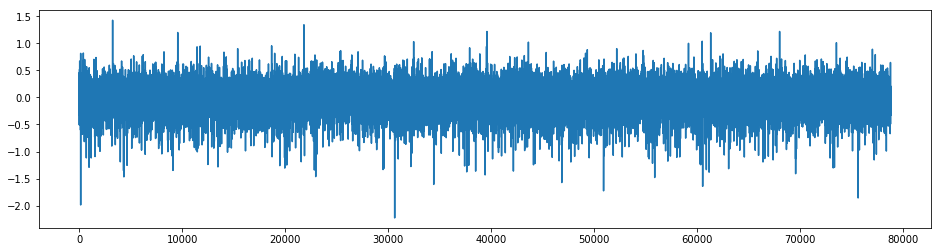

In [116]:
plt.figure(figsize=(16,4))
plt.plot(Y-cvpred)

In [112]:
badID = np.argmax(Y-cvpred)
print(Y[badID])
print(df.loc[badID])
df['cvpred'] = cvpred
df['lincvpred'] = 10**cvpred
df['deltapred'] = abs(Y-cvpred)
df['lindeltapred'] = 10**Y-10**cvpred



10.866
SDSS_ID         1237665537075511390
RA                          233.738
DEC                         23.5037
D25                         0.57544
redshi                       0.0184
GalSize_kpc                 13.1998
D_Mpc             78.85714460696492
d_pix_kpc                  0.152924
logMstar                     10.866
err_logMstar                  0.016
Distance                    78.8571
lin_mass                7.34514e+10
lin_err                 2.70605e+09
hasFile                        True
pred                        10.6203
lin_pred                4.17124e+10
cvpred                      9.44061
lincvpred               2.75809e+09
deltapred                   1.42539
lindeltapred                26.6312
Name: 3251, dtype: object


In [113]:
print(prefixThisRound)

df.to_csv(prefixThisRound + '-CVResultDF.csv')

sp-newSource-ReadLog1pNormCrop.75-model5


In [114]:
df.sort_values(by='deltapred', ascending=False).iloc[:20,:]

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile,pred,lin_pred,cvpred,lincvpred,deltapred,lindeltapred
30653,1237660344469487651,135.06345,35.72214,0.851138,0.0102,10.823047,43.714287291680066,0.084773,7.412,0.008,43.714287,2.582260e+07,4.756699e+05,True,7.572723,3.738723e+07,9.638457,4.349672e+09,2.226457,-4.323849e+09
147,1237661069236175081,122.46120,6.71449,0.645654,0.0509,40.970110,218.1428617664746,0.423035,8.336,0.066,218.142862,2.167704e+08,3.294273e+07,True,8.954748,9.010475e+08,10.322836,2.102982e+10,1.986836,-2.081305e+10
75676,1237661872942284878,191.02245,45.00159,0.933254,0.0124,14.426835,53.1428586691618,0.103058,7.376,0.114,53.142859,2.376840e+07,6.239080e+06,True,9.123011,1.327429e+09,9.233909,1.713597e+09,1.857909,-1.689828e+09
50947,1237671769072533603,227.57250,58.17851,0.645654,0.0307,24.710851,131.571428584201,0.255151,8.804,0.067,131.571429,6.367955e+08,9.824048e+07,True,9.159124,1.442528e+09,10.529992,3.388383e+10,1.725992,-3.324703e+10
60573,1237670449986666600,139.67625,16.47949,0.645654,0.0338,27.206083,144.85713626657213,0.280915,8.660,0.089,144.857136,4.570882e+08,9.367112e+07,True,8.889101,7.746426e+08,10.303047,2.009312e+10,1.643047,-1.963604e+10
34447,1237661850392133667,173.72055,44.00488,0.549541,0.0185,12.674215,79.2857153075082,0.153755,7.934,0.071,79.285715,8.590135e+07,1.404346e+07,True,8.321589,2.096955e+08,9.541323,3.477946e+09,1.607323,-3.392045e+09
46889,1237656496721494169,353.39055,15.54683,0.602560,0.0218,16.375924,93.4285723737308,0.181182,8.258,0.084,93.428572,1.811340e+08,3.503442e+07,True,8.594817,3.933843e+08,9.830957,6.775745e+09,1.572957,-6.594611e+09
55916,1237668271362474177,204.55215,18.39659,0.575440,0.0262,18.795359,112.28571512869426,0.217751,7.929,0.062,112.285715,8.491805e+07,1.212292e+07,True,8.165567,1.464086e+08,9.408943,2.564145e+09,1.479943,-2.479227e+09
4347,1237657071694053618,22.95135,0.66497,0.436516,0.0431,23.454522,184.71428326198034,0.358208,8.530,0.139,184.714283,3.388442e+08,1.084502e+08,True,8.740884,5.506604e+08,9.998160,9.957725e+09,1.468160,-9.618881e+09
22983,1237652933495881852,316.34745,-7.75414,0.741310,0.0281,25.969026,120.4285744045462,0.233542,8.968,0.061,120.428574,9.289664e+08,1.304805e+08,True,9.391002,2.460377e+09,10.431449,2.700529e+10,1.463449,-2.607632e+10


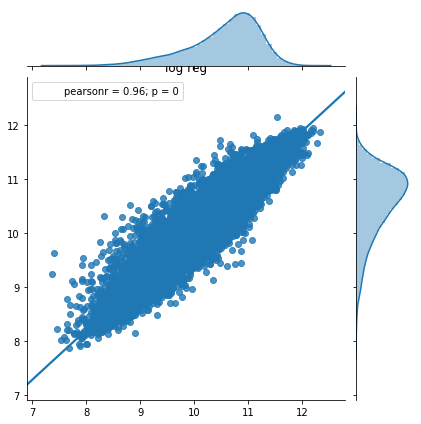

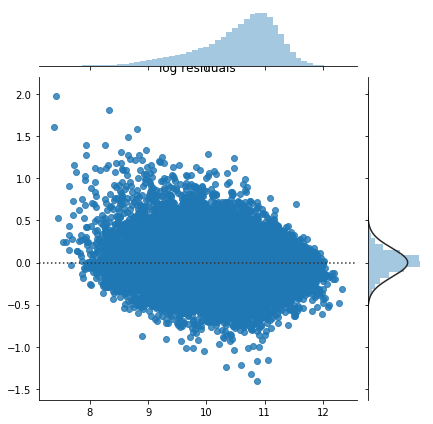

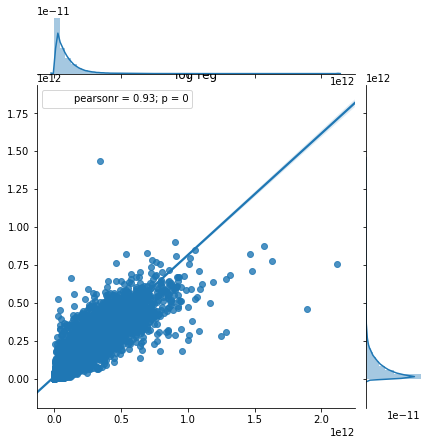

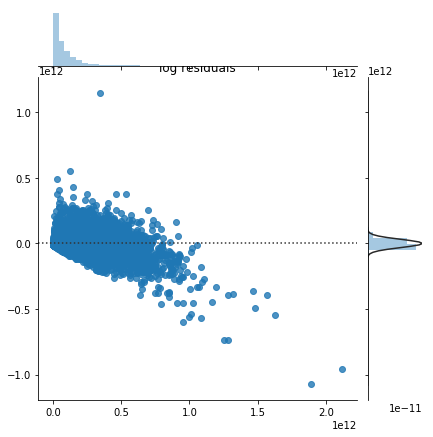

In [102]:
sns.jointplot(x=Y, y=cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y, y=cvpred, kind='resid')
plt.title('log residuals')

sns.jointplot(x=10**Y, y=10**cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=10**Y, y=10**cvpred, kind='resid')
plt.title('log residuals')


# Model is trained, values are obtained, saving and result analysis below

In [50]:
# break here, save the stuff below

In [51]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

(3075,)


3067

In [52]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)[:50]

[(2348, 'sp-newSource-ReadLog1pNormCrop.75-model5.width'),
 (1767, 'sp-newSource-ReadLog1pNormCrop.75-model5.pre.flux.std'),
 (1617, 'sp-newSource-ReadLog1pNormCrop.75-model5.pre.flux.sum'),
 (1520, 'sp-newSource-ReadLog1pNormCrop.75-model5.norm.flux.sum'),
 (1350, 'sp-newSource-ReadLog1pNormCrop.75-model5.pre.flux.mean'),
 (1306, 'sp-newSource-ReadLog1pNormCrop.75-model5.norm.flux.mean'),
 (1135, 'sp-newSource-ReadLog1pNormCrop.75-model5.pre.aroundCenter.flux'),
 (1016, 'sp-newSource-ReadLog1pNormCrop.75-model5.center.flux'),
 (876, 'sp-newSource-ReadLog1pNormCrop.75-model5.1/D'),
 (823, 'sp-newSource-ReadLog1pNormCrop.75-model5.aroundCenter.flux'),
 (782, 'sp-newSource-ReadLog1pNormCrop.75-model5.pre.flux.min'),
 (682, 'sp-newSource-ReadLog1pNormCrop.75-model5.D'),
 (604, 'sp-newSource-ReadLog1pNormCrop.75-model5.1/D**2'),
 (602, 'sp-newSource-ReadLog1pNormCrop.75-model5.1/log(D)**2'),
 (587, 'sp-newSource-ReadLog1pNormCrop.75-model5.1/log(D)'),
 (581, 'sp-newSource-ReadLog1pNormCrop

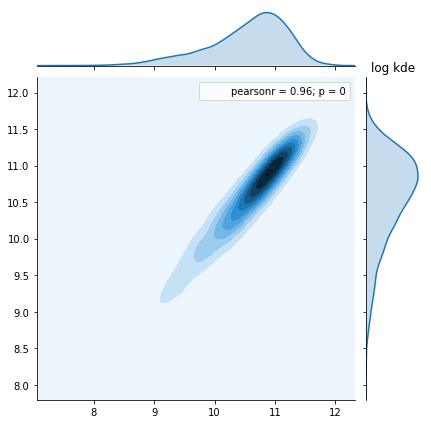

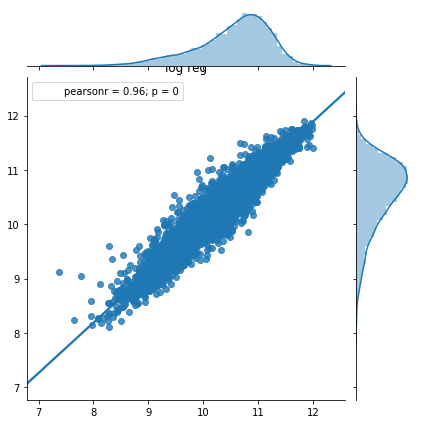

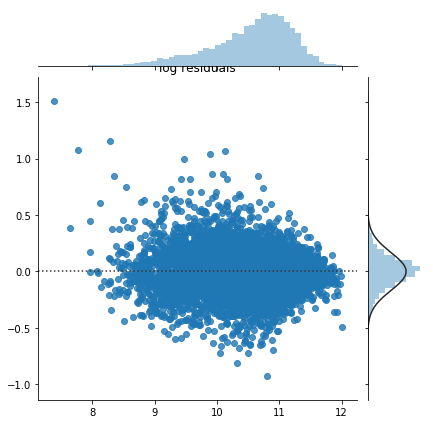

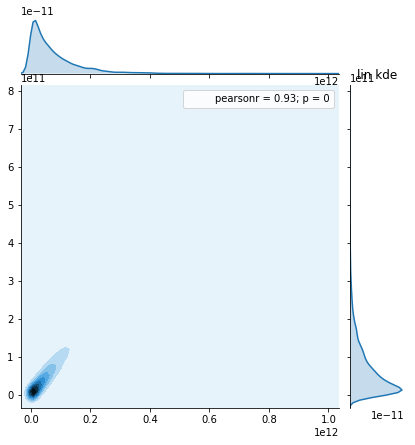

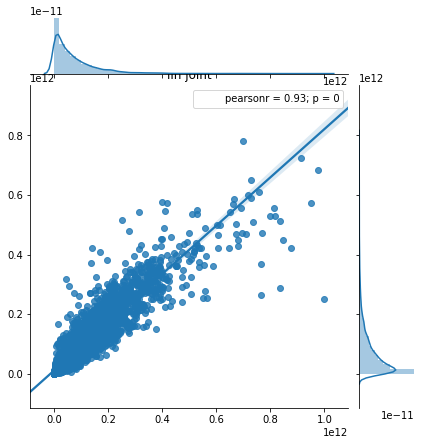

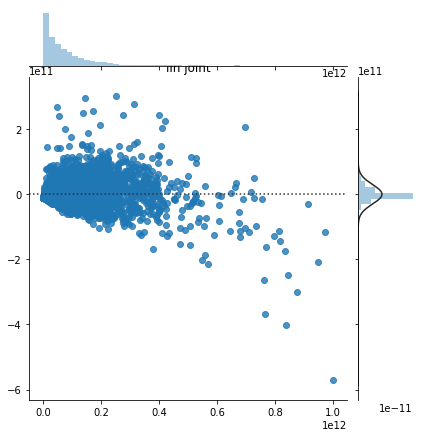

In [53]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)


In [54]:
df[df['logMstar']>=12]

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
5259,1237661852529262721,143.16420,37.88729,0.831764,0.1910,198.053588,818.5714270387377,1.587419,12.012,0.008,818.571427,1.028016e+12,1.893676e+10,True
10879,1237651190281797662,126.37110,47.13344,0.912011,0.1290,146.669225,552.8571137360165,1.072131,12.109,0.019,552.857114,1.285287e+12,5.623016e+10,True
14206,1237651226781483185,258.04095,61.72065,0.630957,0.1728,135.923044,740.5714477811541,1.436157,12.195,0.008,740.571448,1.566751e+12,2.886062e+10,True
19730,1237667735030923424,149.11695,18.51733,0.489779,0.1608,98.182788,689.1428359917232,1.336424,12.004,0.029,689.142836,1.009253e+12,6.739283e+10,True
27394,1237661139034046481,154.26510,39.04710,0.524807,0.2056,134.515539,881.142829145704,1.708760,12.023,0.002,881.142829,1.054387e+12,4.855631e+09,True
29195,1237658803106480214,164.17395,54.14696,0.616595,0.2215,170.264094,949.2856902735574,1.840907,12.171,0.021,949.285690,1.482518e+12,7.168610e+10,True
30470,1237659326565384653,246.05835,41.24372,0.575440,0.1832,131.424035,785.1428644997733,1.522592,12.007,0.012,785.142864,1.016249e+12,2.807999e+10,True
31223,1237658206120902850,180.54525,51.06611,0.436516,0.2864,155.855566,1227.4285299437386,2.380297,12.004,0.025,1227.428530,1.009253e+12,5.809727e+10,True
32698,1237658204512125144,187.06710,49.83949,0.457088,0.2637,150.265576,1130.142893110003,2.191635,12.028,0.008,1130.142893,1.066596e+12,1.964743e+10,True
37614,1237654626789163411,120.23685,36.05654,0.407380,0.2873,145.909967,1231.285674231393,2.387777,12.109,0.013,1231.285674,1.285287e+12,3.847326e+10,True


In [55]:
print(df.shape)
print(pred.shape)

(78851, 14)
(7886,)


12.0 11.3970973751
1e+12 249515411388.0
SDSS_ID         1237668350286364856
RA                          221.987
DEC                         14.7591
D25                        0.489779
redshi                       0.2146
GalSize_kpc                 131.033
D_Mpc             919.7142720222473
d_pix_kpc                   1.78356
logMstar                         12
err_logMstar                  0.009
Distance                    919.714
lin_mass                      1e+12
lin_err                 2.07233e+10
hasFile                        True
Name: 77873, dtype: object
1237668350286364856


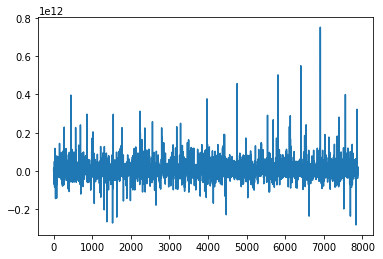

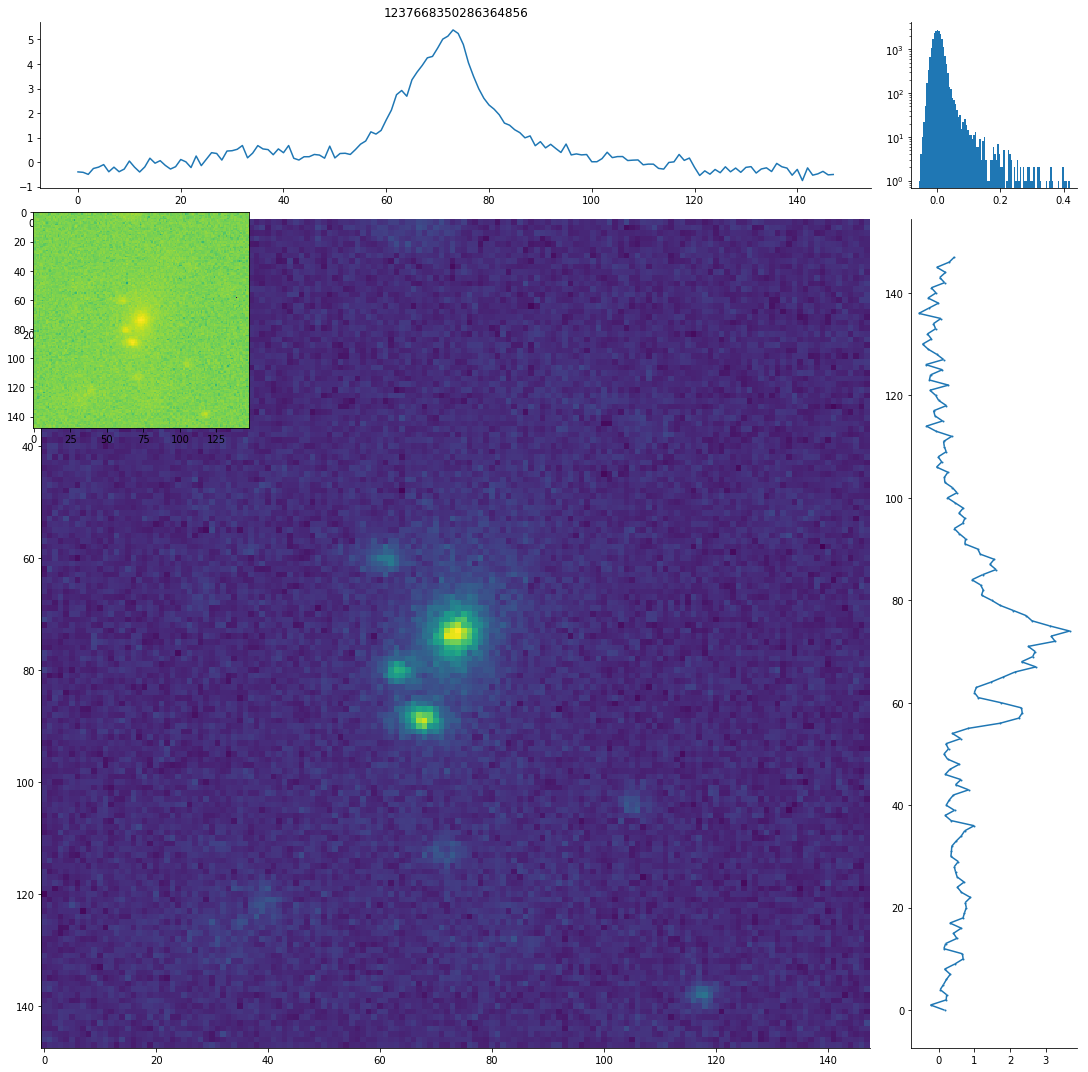

In [56]:
plt.plot(10**Y[M:]-10**pred)
worstID = np.argmax(10**Y[M:]-10**pred)

print(Y[M+worstID], pred[worstID])
print(10**Y[M+worstID], 10**pred[worstID])
print(df.loc[M+worstID,:]) # 1237664105244524770, 1237661851469611060 1237654626789163411

# pred[worstID] = Y[M+worstID]

drawOneGalaxy(df.loc[M+worstID,'SDSS_ID'])

In [57]:
# Warning: predictions from here on will contain data from training set: 
pred = model.predict(Xg3f[:])



In [58]:
pred.shape

(78851,)

In [59]:
df['pred'] = pred
df['lin_pred'] = 10**pred

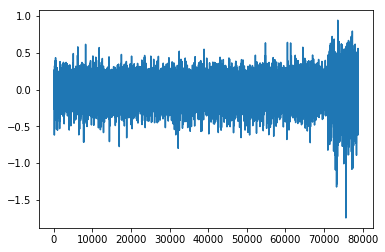

In [60]:
plt.plot(Y[:]-pred)

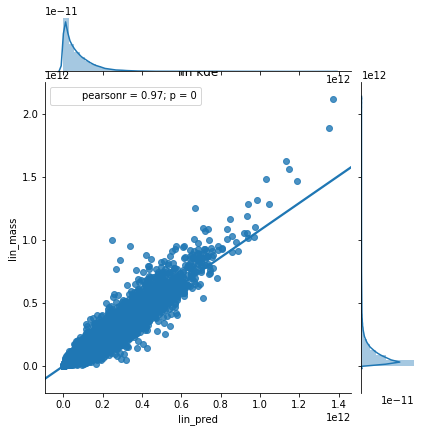

In [61]:
sns.jointplot(data=df, x='lin_pred', y='lin_mass', kind='reg')
plt.title('lin kde')
